In [1]:

import numpy             as np
import matplotlib.pyplot as plt
import glob
import h5py as h
import random
%matplotlib inline

In [2]:
def Hist2d(title,Energys,Times,binss,xlimit,ylimit):
    fig,ax = plt.subplots(figsize=(8,8))
    plt.hist2d(Energys,Times,bins=binss,cmap=plt.cm.BuGn_r)
    plt.title(title)

    plt.ylabel("Energy keV",fontsize=26)
    plt.xlabel("Time us",fontsize=26)
    plt.tick_params('both', length=10, width=2, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.grid(True)
    plt.tight_layout()

    ##plt.savefig('/home/ilker/Dropbox/nexus/build/source/'+title + '.png')
    plt.show()
    
def Hist1d(title,Energys,Bins,xlimit,ylimit,limits=False):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.hist(Energys,bins=Bins,alpha=0.3,density=True,stacked=True,label=title)
    plt.ylabel("Counts",fontsize=26)
    plt.xlabel("Energy keV",fontsize=26)
    plt.tick_params('both', length=10, width=2, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.legend(loc='upper right',fontsize=24,shadow=True, fancybox=True)
    #plt.semilogy()
    if(limits):
        plt.xlim(xlimit)
        plt.ylim(ylimit)
    plt.grid(True)
    plt.tight_layout()

    #plt.savefig('/Users/austinmcdonald/Desktop/'+title + '.png')
    #plt.show()
def Plot2d(title,x,y):
    fig,ax = plt.subplots(figsize=(8,8))
    plt.plot(x,y)
    plt.scatter(x,y)
    plt.title(title)
    plt.ylabel("Z mm",fontsize=26)
    plt.xlabel("Y mm",fontsize=26)
    plt.tick_params('both', length=10, width=2, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def Circle(pltX,pltY,title):
  
    fig,ax = plt.subplots(figsize=(8,8))
    plt.title(title)
    plt.plot(pltX,pltY)
 

    plt.scatter(pltX,pltY)
    circle1 = plt.Circle((0, 0), 35, color='r',fill=False)
    circle2 = plt.Circle((0, 0), 75, color='k',fill=False)
    ax.add_patch(circle1)
    ax.add_patch(circle2)
 
    plt.xlim(-100,100)
    plt.ylim(-100,100)

    plt.ylabel("Z (mm)",fontsize=26)
    plt.xlabel("Y (mm)",fontsize=26)
    plt.tick_params('both', length=10, width=2, which='major')
    plt.tick_params('both', length=5, width=1, which='minor')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [3]:
def EnergyAndTracks(file,EventLimit=0,particle=b'alpha',Mother=False,fudicalR=-1,AllEvents=False):
    data = h.File(file,'r')
    TotalEvents=int(data['MC']['configuration'][2][1])
    if(EventLimit>0):
        TotalEvents=EventLimit
    
    theEvents={}

    for Current_Event in range(0,TotalEvents):
        
        Current_Hit_Mask = data["MC"]['hits']['event_id'] == Current_Event 

        Current_Particle_Mask = data["MC"]['particles']['event_id'] == Current_Event

        Particle_Mask = data["MC"]['particles'][Current_Particle_Mask]['particle_name'] == particle
        
        Particle_PIDS = data["MC"]['particles'][Current_Particle_Mask][Particle_Mask]['particle_id']
      
        if(Mother):
            Mother_PIDS = data["MC"]['particles'][Current_Particle_Mask][Particle_Mask]['mother_id']
            Mother_Mask = data["MC"]['particles'][Current_Particle_Mask]['particle_name'] == Mother
            Mother_PID  = data["MC"]['particles'][Current_Particle_Mask][Mother_Mask]['particle_id']
            SameMotherMask  = np.in1d( Mother_PIDS,Mother_PID)
            Particle_PIDS = data["MC"]['particles'][Current_Particle_Mask][Particle_Mask][SameMotherMask]['particle_id']
        
                  
        A = data["MC"]['hits'][Current_Hit_Mask]['particle_id']
        Hit_Particle_Mask = np.in1d(A, Particle_PIDS)
            
        ElectronData=data["MC"]['hits'][Current_Hit_Mask][Hit_Particle_Mask]
        TotalEventEnergy=ElectronData["energy"].sum()*1e3

        Xhits=data["MC"]['hits'][Current_Hit_Mask][Hit_Particle_Mask]["x"]
        Yhits=data["MC"]['hits'][Current_Hit_Mask][Hit_Particle_Mask]["y"]
        Zhits=data["MC"]['hits'][Current_Hit_Mask][Hit_Particle_Mask]["z"]

        #Checking the Radius if in the boundaries
        if(not fudicalR==-1):
            fRadius=np.sqrt(Yhits*Yhits+Zhits*Zhits)
            fRadius_Mask=fRadius<=fudicalR
            TrksCntIntheFudi=np.count_nonzero(fRadius_Mask)
        
        Tracks=np.array([Xhits,Yhits,Zhits])
        theEvents[Current_Event]=[Tracks,TotalEventEnergy]

        
    return theEvents

def PlotRandomEvents(file,NPlots,particle,Energy,EventLimit=0):
    theEvents=EnergyAndTracks(file,EventLimit=EventLimit,particle=particle,AllEvents=False)
    QualfEnergys=[]    
    for Event in theEvents:
        if(theEvents[Event][1]>=Energy):
            QualfEnergys.append(Event)

    for plot in range(0,NPlots):
        Event=random.choice(QualfEnergys)
        print(Event)
        title="Track with " + str(theEvents[Event][1]) + " keV"
        Circle(theEvents[Event][0][1],theEvents[Event][0][2],title)

        
def PlotEnergySpec(theEvents,title,binss=np.arange(1,5500,100)):
    Energys=[]
    for Event in theEvents:
        Energys.append(theEvents[Event][1])
        
    print (len(Energys))    
    Hist1d(title,Energys,binss,"Counts","Energy (keV)")
    
def GetEnergySpec(theEvents):
    Energys=[]
    for Event in theEvents:
        Energys.append(theEvents[Event][1])
        
    return Energys
    

In [18]:
#file = "/home/ilker/Dropbox/nexus/build/source/Cs137_2mm12.h5"
file="/home/ilker/Projects/latest_Nexus/alphas.h5"
#Alphas=EnergyAndTracks(file,EventLimit=1000,particle=b'alpha',AllEvents=False)
#BetasFromBi210=EnergyAndTracks(file,EventLimit=100,particle=b'e-',Mother=b'Bi210',AllEvents=False)
Betas=EnergyAndTracks(file,EventLimit=10000,particle=b'e-',Mother=b'Bi210',AllEvents=False)


#gamma=EnergyAndTracks(file,EventLimit=1000,particle=b'gamma',AllEvents=False)

In [16]:
Alphas=EnergyAndTracks(file,EventLimit=1000,particle=b'alpha',AllEvents=False)


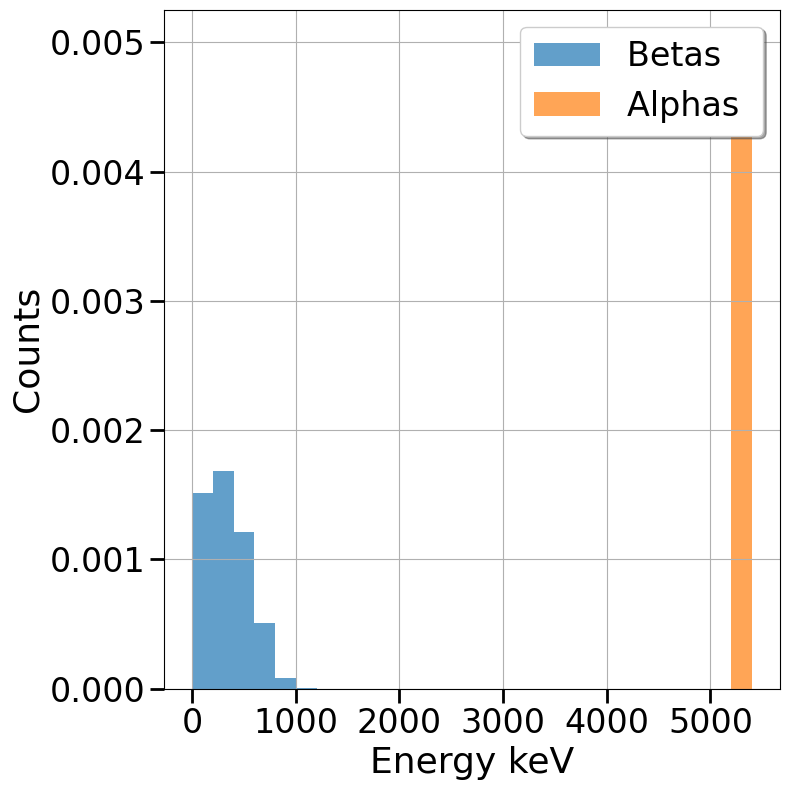

In [20]:
Bins=np.arange(1,5500,200)
limits=False
fig, ax = plt.subplots(figsize=(8,8))
#plt.hist(GetEnergySpec(Alphas),bins=Bins,alpha=0.7,density=True,stacked=True,label="Alphas")
plt.hist(GetEnergySpec(Betas),bins=Bins,alpha=0.7,density=True,stacked=True,label="Betas ")
plt.hist(GetEnergySpec(Alphas),bins=Bins,alpha=0.7,density=True,stacked=True,label="Alphas ")

#plt.hist(GetEnergySpec(gamma),bins=Bins,alpha=0.7,density=True,stacked=True,label="gamma")


plt.ylabel("Counts",fontsize=26)
plt.xlabel("Energy keV",fontsize=26)
plt.tick_params('both', length=10, width=2, which='major')
plt.tick_params('both', length=5, width=1, which='minor')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(loc='upper right',fontsize=24,shadow=True, fancybox=True)
#plt.semilogy()

plt.grid(True)
plt.tight_layout()

In [7]:
print(BetasFromPb210[99][1])

NameError: name 'BetasFromPb210' is not defined

In [ ]:
Hist1d('Energy Spectrum of Cs137',E,np.arange(1,800,10),0,0)
print(len(E))

In [ ]:
file="/home/ilker/Dropbox/nexus/build/source/Ba133_2mm222.h5"
BaE=getEnergys(file)

In [ ]:
Hist1d('Energy Spectrum of Ba133',BaE,np.arange(1,500,10),0,0)
print(len(BaE))

In [ ]:
file="/home/ilker/Dropbox/nexus/build/source/Cs137_2mm12.h5"
BaE2=getEnergys(file)

In [ ]:
A=getTracks("/home/ilker/Dropbox/nexus/build/source/Cs137_2mm12.h5",547)

#B=dicEnergyAndTracks("/home/ilker/Dropbox/nexus/build/source/Cs137_2mm12.h5",1000)


In [ ]:
Plot2d("A Track",A[2],A[1])
Circle(A[2],A[1],"test")
print (A[2])

In [ ]:
PlotRandomEvents("/home/ilker/Dropbox/nexus/build/source/Cs137_2mm12.h5",5,400,EventLimit=1000)